In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# 1. Đọc dữ liệu

In [3]:
DATA_DIR = "../data/cleaned_data"
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_DIR, "val.csv"))
test_df  = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)

feature_cols = [c for c in train_df.columns if c not in ('CLASS', 'NSP')]

Train: (1721, 23) Val: (192, 23) Test: (213, 23)


# 2. Tách X/y

In [4]:
df_trval = pd.concat([train_df, val_df], ignore_index=True)
X_trval = df_trval[feature_cols].values
X_test  = test_df[feature_cols].values
y_trval_class = df_trval['CLASS'].values
y_trval_nsp   = df_trval['NSP'].values
y_test_class  = test_df['CLASS'].values
y_test_nsp    = test_df['NSP'].values

Pipeline & param_grid cho GaussianNB

In [5]:
pipe_gnb = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote',  SMOTE(random_state=42)),
    ('skb',    SelectKBest(f_classif)),      # chọn feature
    ('clf',    GaussianNB())
])

param_gnb = {
    'skb__k': [10, 15, 20, len(feature_cols)],
    'clf__var_smoothing': [1e-12, 1e-9, 1e-6, 1e-3]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs_gnb_class = GridSearchCV(pipe_gnb, param_gnb, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
gs_gnb_nsp   = GridSearchCV(pipe_gnb, param_gnb, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)

Pipeline & param_grid cho MultinomialNB

In [6]:
pipe_mnb = ImbPipeline([
    ('scaler', MinMaxScaler()),             # đưa về [0,1]
    ('smote',  SMOTE(random_state=42)),
    ('skb',    SelectKBest(f_classif)),
    ('clf',    MultinomialNB())
])

param_mnb = {
    'skb__k': [10, 15, 20, len(feature_cols)],
    'clf__alpha': [0.0, 0.1, 0.5, 1.0],
    'clf__fit_prior': [True, False]
}

gs_mnb_class = GridSearchCV(pipe_mnb, param_mnb, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
gs_mnb_nsp   = GridSearchCV(pipe_mnb, param_mnb, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)

# 3. Huấn luyện models

3.1. MODEL 1: Gaussian Naive Bayes

Đánh giá CLASS

In [12]:
gs_gnb_class.fit(X_trval, y_trval_class)
best_gnb_class = gs_gnb_class.best_estimator_
y_pred_gnb_c = best_gnb_class.predict(X_test)

print("=== GNB CLASS ===")
print("Best params:", gs_gnb_class.best_params_)
print("Test Accuracy:", accuracy_score(y_test_class, y_pred_gnb_c))
print(classification_report(y_test_class, y_pred_gnb_c))
print(confusion_matrix(y_test_class, y_pred_gnb_c))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
=== GNB CLASS ===
Best params: {'clf__var_smoothing': 0.001, 'skb__k': 15}
Test Accuracy: 0.6807511737089202
              precision    recall  f1-score   support

           0       0.80      0.35      0.49        34
           1       0.90      0.62      0.74        56
           2       0.42      0.83      0.56         6
           3       0.28      1.00      0.43         5
           4       0.35      0.75      0.48         8
           5       0.90      0.88      0.89        32
           6       0.84      0.75      0.79        28
           7       0.64      1.00      0.78         9
           8       0.45      0.56      0.50         9
           9       0.61      0.73      0.67        26

    accuracy                           0.68       213
   macro avg       0.62      0.75      0.63       213
weighted avg       0.76      0.68      0.69       213

[[12  2  5  0  6  0  0  0  1  8]
 [ 0 35  1 13  3  1  3  0  0  0]
 [ 1 

Đánh giá NSP

In [8]:
gs_gnb_nsp.fit(X_trval, y_trval_nsp)
best_gnb_nsp = gs_gnb_nsp.best_estimator_
y_pred_gnb_n = best_gnb_nsp.predict(X_test)

print("\n=== GNB NSP ===")
print("Best params:", gs_gnb_nsp.best_params_)
print("Test Accuracy:", accuracy_score(y_test_nsp, y_pred_gnb_n))
print(classification_report(y_test_nsp, y_pred_gnb_n))
print(confusion_matrix(y_test_nsp, y_pred_gnb_n))

Fitting 5 folds for each of 16 candidates, totalling 80 fits

=== GNB NSP ===
Best params: {'clf__var_smoothing': 0.001, 'skb__k': 15}
Test Accuracy: 0.7699530516431925
              precision    recall  f1-score   support

           0       0.99      0.76      0.86       159
           1       0.48      0.86      0.62        36
           2       0.44      0.67      0.53        18

    accuracy                           0.77       213
   macro avg       0.64      0.76      0.67       213
weighted avg       0.86      0.77      0.79       213

[[121  27  11]
 [  1  31   4]
 [  0   6  12]]


3.2. MODEL 2: Multinomial Naive Bayes

Dự đoán và đánh giá CLASS

In [9]:
gs_mnb_class.fit(X_trval, y_trval_class)
y_pred_mnb_c = gs_mnb_class.predict(X_test)

print("=== MNB CLASS ===")
print("Best params:", gs_mnb_class.best_params_)
print("Test Accuracy:", accuracy_score(y_test_class, y_pred_mnb_c))
print(classification_report(y_test_class, y_pred_mnb_c))
print(confusion_matrix(y_test_class, y_pred_mnb_c))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
=== MNB CLASS ===
Best params: {'clf__alpha': 0.1, 'clf__fit_prior': True, 'skb__k': 20}
Test Accuracy: 0.6150234741784038
              precision    recall  f1-score   support

           0       0.67      0.29      0.41        34
           1       0.93      0.66      0.77        56
           2       0.29      0.83      0.43         6
           3       0.31      0.80      0.44         5
           4       0.23      0.38      0.29         8
           5       0.86      0.75      0.80        32
           6       0.70      0.82      0.75        28
           7       0.64      0.78      0.70         9
           8       0.41      0.78      0.54         9
           9       0.42      0.42      0.42        26

    accuracy                           0.62       213
   macro avg       0.54      0.65      0.56       213
weighted avg       0.69      0.62      0.62       213

[[10  1  8  0  2  0  0  0  0 13]
 [ 1 37  1  9  3  3  2 

Dự đoán và đánh giá NSP

In [10]:
gs_mnb_nsp.fit(X_trval, y_trval_nsp)
y_pred_mnb_n = gs_mnb_nsp.predict(X_test)

print("\n=== MNB NSP ===")
print("Best params:", gs_mnb_nsp.best_params_)
print("Test Accuracy:", accuracy_score(y_test_nsp, y_pred_mnb_n))
print(classification_report(y_test_nsp, y_pred_mnb_n))
print(confusion_matrix(y_test_nsp, y_pred_mnb_n))

Fitting 5 folds for each of 32 candidates, totalling 160 fits

=== MNB NSP ===
Best params: {'clf__alpha': 0.0, 'clf__fit_prior': True, 'skb__k': 15}
Test Accuracy: 0.704225352112676
              precision    recall  f1-score   support

           0       0.97      0.70      0.81       159
           1       0.43      0.83      0.57        36
           2       0.31      0.50      0.38        18

    accuracy                           0.70       213
   macro avg       0.57      0.68      0.59       213
weighted avg       0.83      0.70      0.74       213

[[111  31  17]
 [  3  30   3]
 [  0   9   9]]


# 4. So sánh

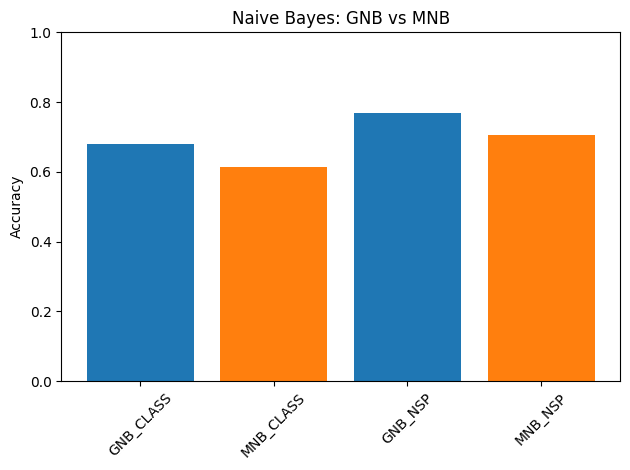

In [11]:
accs = [
    accuracy_score(y_test_class, y_pred_gnb_c),
    accuracy_score(y_test_class, y_pred_mnb_c),
    accuracy_score(y_test_nsp,   y_pred_gnb_n),
    accuracy_score(y_test_nsp,   y_pred_mnb_n)
]
labels = ['GNB_CLASS','MNB_CLASS','GNB_NSP','MNB_NSP']
colors = ['tab:blue','tab:orange','tab:blue','tab:orange']

plt.figure()
plt.bar(labels, accs, color=colors)
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('Naive Bayes: GNB vs MNB')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()